### Chapter 6 Figures

Figures that accompany the XGB-TBSContext. 

Assumes that the data output from feature analsysis is located in 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ranksums, wilcoxon
import numpy as np

import pybedtools
%matplotlib inline

#to ensure the sequences are not truncated
pd.set_option('display.max_colwidth', -1)

#Set path for the figures
figure_path = "/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter6/Figs"

/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Calculate Wilcoxon ranksum test and the effect size

### Effect size

This is adapted from: https://github.com/bagrow/datatools/blob/master/bin/ranksum

In this,we are using Cohens effect size, which can be interpreted as follows:
    - None 0
    - Small 0.2
    - Medium 0.5
    - Large 0.8
    - Very large 1.3
    
 I should provide some details for interpreting effect size

In [2]:
def get_stat_wilcoxon_effect_size(sample1,sample2):
    X1 = np.array(sample1)
    X2 = np.array(sample2)
    n1 = len(sample1)
    n2 = len(sample2)
    m1 = np.mean(X1)
    m2 = np.mean(X2)
    s1 = np.std(X1,ddof=1)
    s2 = np.std(X2,ddof=1)

    s = np.sqrt( ((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2) )
    return ranksums(sample1,sample2)[1],(m2-m1)/s

# Machine learning features

#### Feature importance by eliminating one, sequentially

The main observation here is that the DNase and the TSS as the most informative features. Next, we eliminate all least contributing features and only retain the core features. as follows:
* Dnase
* Tss
* Phastcons
* max Kmer score
* Hg-dn normalized to noise

In [154]:
# Set to this for display, but to paper for the thesis
sns.set(style="whitegrid", context="paper")

In [111]:
map_names = {}
for feat in list(TF_scores_all.columns):
    map_names[feat] = feat
map_names["kmer_score"] = "sum_kmer_score"
map_names["dn_hg_score2"] = "hg_dn_score"
map_names["kmer_score"] = "sum_kmer_score"
map_names["dnase"] = "dnase"
map_names["max_kmer_score"] = "max_kmer_score"
map_names["phyloP100way"] = "phyloP100way"
map_names["None"] = "None"

In [112]:
def map_names_fun(df):
    df.columns = [map_names[feat] for feat in list(df.columns)]
    return df

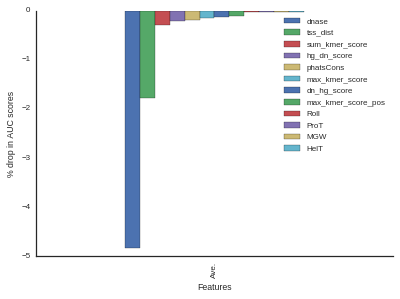

In [101]:
TF_scores_best = pd.read_table("TF_scores_feature_importance_recursive_pop.txt", index_col="Tf_name")

map_names = {}
for feat in list(TF_scores_best.columns):
    map_names[feat] = feat
map_names["kmer_score"] = "sum_kmer_score"
map_names["dn_hg_score2"] = "hg_dn_score"
map_names["kmer_score"] = "sum_kmer_score"
map_names["dnase"] = "dnase"
map_names["max_kmer_score"] = "max_kmer_score"
map_names["phyloP100way"] = "phyloP100way"

TF_scores_best = TF_scores_best.T
TF_scores_best["Ave."] = TF_scores_best.T.mean()
TF_scores_best = TF_scores_best.T
del TF_scores_best["Unnamed: 14"]

TF_scores_best = map_names_fun(TF_scores_best)
#[map_names[feat] for feat in list(TF_scores_best.columns)]

abc = ((TF_scores_best.T["Ave."] - TF_scores_best.T["Ave."].All)*100)
abc.sort_values(inplace=True, ascending=True)
abc_df_pop = pd.DataFrame(abc).T
del abc_df_pop["All"]


ax= abc_df_pop.plot.bar()
ax.set_ylabel("% drop in AUC scores")
ax.set_xlabel("Features")
sns.despine()
fig = ax.get_figure()
#fig.savefig("%s/feature_importance_all.pdf" % figure_path)
# abc = (TF_scores_best.T["Ave."].sort_values(ascending=False) - TF_scores_best.T["Ave."].max()) * 100

# ax= pd.DataFrame(abc).T.plot.bar()
# fig = ax.get_figure()

In [8]:
df_columns = list(abc_df_pop.columns)

In [114]:
get_stat_wilcoxon_effect_size(TF_scores_best.All, TF_scores_best.dnase)

(0.027727015543251528, -0.62430755171814722)

In [115]:
wilcoxon(TF_scores_best.All, TF_scores_best.dnase)

WilcoxonResult(statistic=0.0, pvalue=5.9569779074563588e-05)

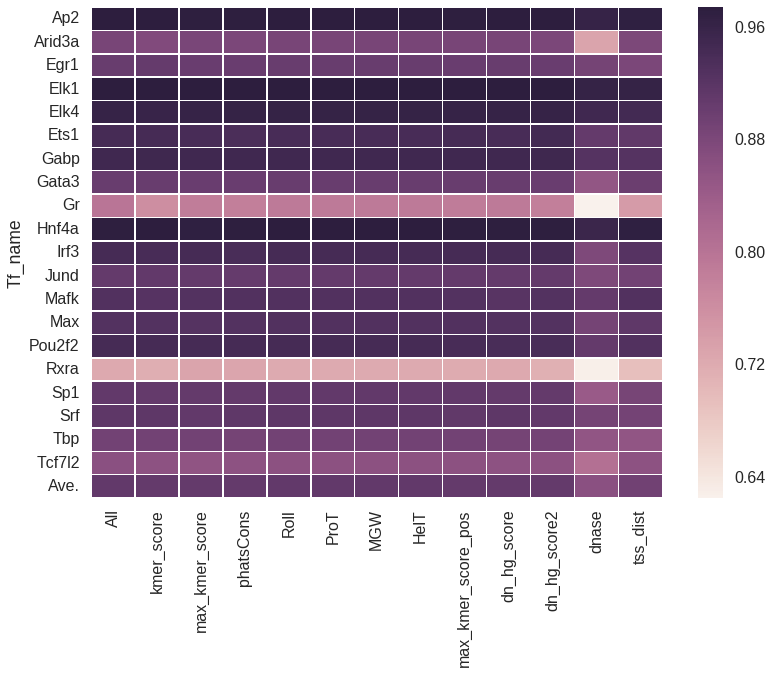

In [19]:
sns.heatmap(TF_scores_best)

In [50]:
fig.savefig("%s/feature_importance_recursive.png" % figure_path)

## Feature importance by addition

We test the feature importance by starting with the baseline model (dnase and max_kmer_score), test the contribution of each of the additional features, as well as the value of using all the best features. This tell us how important a feature is when added to the baseline model of DNase and max_kmer score.

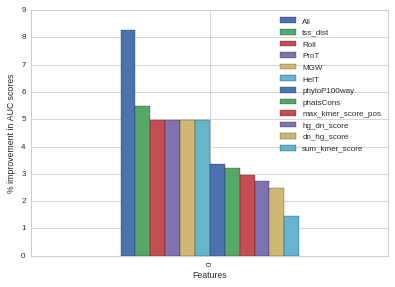

In [156]:
TF_scores_all = pd.read_table("TF_scores_feature_importance_recursive_all.txt", index_col="Tf_name")
TF_scores_all.columns = [map_names[feat] for feat in list(TF_scores_all.columns)]

test_df = pd.DataFrame(((TF_scores_all.T - TF_scores_all["None"]).T.mean())*100)
test_df.sort_values(by=0, ascending=False, inplace=True)
test_df = test_df.T

del test_df["None"]

ax = test_df.plot(kind="bar")

# abc.sort_values(inplace=True, ascending=False)
# abc_df = pd.DataFrame(abc).T
# del abc_df["None"]
# ax= abc_df.plot.bar()
#ax.set_title('All features')
ax.set_ylabel("% improvement in AUC scores")
ax.set_xlabel("Features")

fig = ax.get_figure()
fig.savefig("%s/feature_importance_additive_all.pdf" % figure_path)

In [62]:
test_kmers = TF_scores_all[["All","sum_kmer_score", "max_kmer_score_pos","None"]]

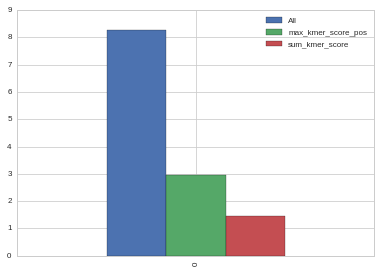

In [84]:
test_kmers_diff = pd.DataFrame(((test_kmers.T - test_kmers["None"]).T.mean())*100)
#test_kmers_diff.columns = [map_names[feat] for feat in list(test_kmers_diff.columns)]

test_kmers_diff.sort_values(by=0, ascending=False, inplace=True)
test_kmers_diff = test_kmers_diff.T
del test_kmers_diff["None"]

test_kmers_diff.plot(kind="bar")

# abc.sort_values(inplace=True, ascending=False)
# abc_df = pd.DataFrame(abc).T
# del abc_df["None"]
# ax= abc_df.plot.bar()
#fig = ax.get_figure()

In [8]:
get_stat_wilcoxon_effect_size(TF_scores_all.All,TF_scores_all.dn_hg_score)

(0.00490497196539969, -0.81115205833493109)

In [262]:
#TF_scores_all.to_csv("TF_scores_feature_importance_recursive_all.txt", sep="\t")

In [253]:
#abc = ((TF_scores_all - TF_scores_all["None"])*100)

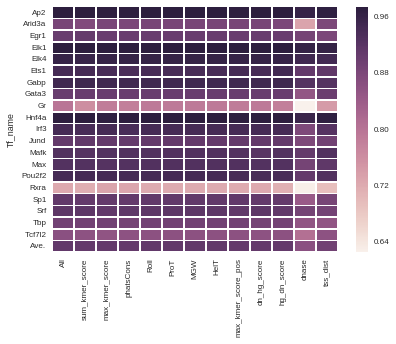

In [67]:
sns.heatmap(TF_scores_best)

From the above, we can clearly demonstrate the performance of tss and dnase, but not of the rest of the features. Therefore we perfrom feature importance analaysis using the best six.  

## Norrow down to certain informative sites


After confirming the overal feature importance, we norrow down to 6 most informative features, and test them further. Here, we are specifically| intersted in eliminating feature with similar informaton. This way, we can confidently measure the importance of each feature individually. 

The only change in the ranking from this is the importance of the tss outperformed by k-mer feature. 

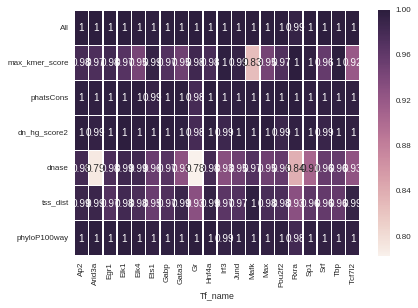

In [85]:
TF_scores_best_6 = pd.read_table("TF_scores_feature_importance_recursive_pop_best6.txt", index_col="Tf_name")
del TF_scores_best_6["Unnamed: 8"]
sns.heatmap(TF_scores_best_6.T/TF_scores_best_6.T.max(), annot=True)

## Feature importance plot

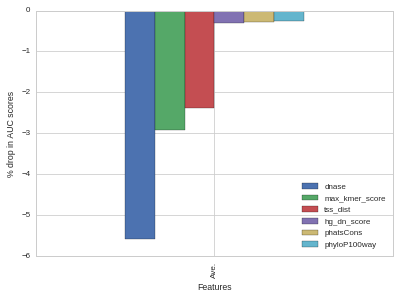

In [105]:
TF_scores_best_6 = pd.read_table("TF_scores_feature_importance_recursive_pop_best6.txt", index_col="Tf_name")

del TF_scores_best_6["Unnamed: 8"]
TF_scores_best_6 = map_names_fun(TF_scores_best_6)

TF_scores_best_6 = TF_scores_best_6.T
TF_scores_best_6["Ave."] = TF_scores_best_6.T.mean()
abc = ((TF_scores_best_6["Ave."] - TF_scores_best_6["Ave."].All)*100)
abc.sort_values(inplace=True, ascending=True)
abc_df = pd.DataFrame(abc).T
del abc_df["All"]
ax= abc_df.plot.bar()
ax.set_ylabel("% drop in AUC scores")
ax.set_xlabel("Features")
fig = ax.get_figure()
fig.savefig("%s/feature_importance_best6.pdf" % figure_path)

In [12]:
get_stat_wilcoxon_effect_size(TF_scores_best_6.T.All,TF_scores_best_6.T.max_kmer_score)

(0.068183650364699852, -0.47557472816282154)

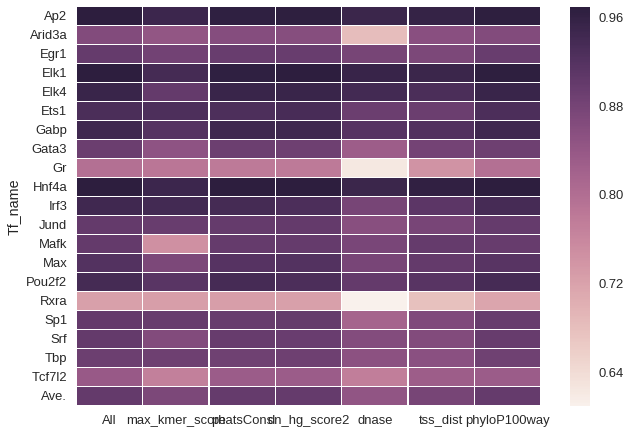

In [13]:
sns.heatmap(TF_scores_best_6.T)

## TF specific feature importance

With this figure, it is easy to observe TF specific importance of the features. For excample, the Arid3a greatly depend on the dnase data and could be linked to poor quality of the k-mer model. On the other hand, Mafk is distinct in that it depends more on the k-mer model for predictive modeling. 

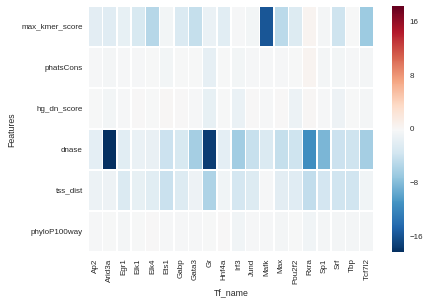

In [92]:
tf_specific = ((TF_scores_best_6 - TF_scores_best_6.T["All"])*100)
tf_specific.drop("All", inplace=True)
del tf_specific["Ave."]
ax = sns.heatmap(tf_specific)
ax.set_ylabel("Features")
plt.savefig("%s/feature_importance_tf_specific.pdf" % figure_path, bbox_inches='tight')

In [15]:
get_stat_wilcoxon_effect_size(TF_scores_best_6.T.All,TF_scores_best_6.T.dnase)

(0.016289081250027936, -0.69877045593066867)

In [356]:
a= ranksums(TF_scores_best_6.T.All, TF_scores_best_6.T.dn_hg_score2)

### Thesis figure combined

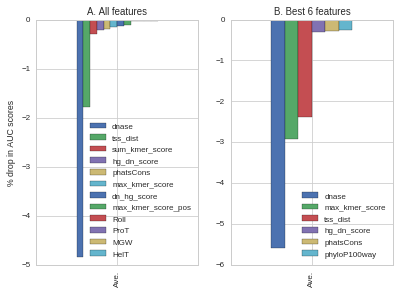

In [107]:
#fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
abc_df_pop.plot.bar(ax=ax1)
abc_df.plot.bar(ax=ax2)
#fig = ax.get_figure()
ax1.set_title('A. All features')
ax2.set_title('B. Best 6 features')
ax1.set_ylabel("% drop in AUC scores")
fig.savefig("%s/feature_importance_best_all.png" % figure_path)

## The contribution of the different shape features

In [113]:
TF_scores_shape = pd.read_table("TF_scores_feature_importance_recursive_shape.txt", index_col="Tf_name")

TF_scores_shape = map_names_fun(TF_scores_shape)
#sns.heatmap(tst3.T/tst3.T.max(), annot=True)

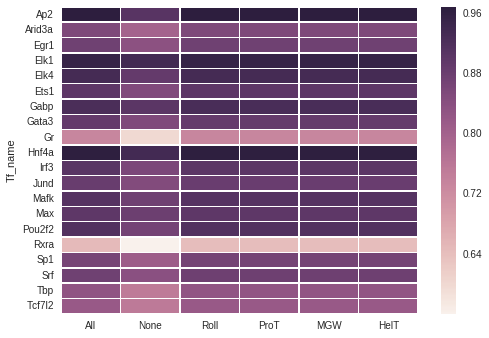

In [153]:
sns.heatmap(TF_scores_shape)

In [48]:
#sns.heatmap(((tst3.T - tst3["All"])*100).T)

## DNA shape feature importance

We observe that the perfomance of the model with any of the shape features is similar....there is no difference in performance among the features. However, I may need to test this further and confirm the contribution of the individual features to the performancr of teh model. 

The figure shows the percentage drop in performance of the model when the shape feature are removed form the model

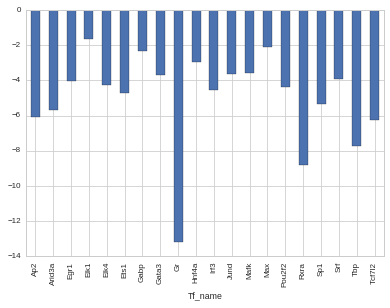

In [98]:
axes = ((TF_scores_shape.T - TF_scores_shape["All"])*100).T["None"].plot.bar()

## Stacked bar plot

Provides the following infromation:
- A similar level of feature contribution by all the shape features
- Eliminating the all shape features leads to significant drop in performance
- Therefore, in the absence of other features...shape information provides significant perfomance improvement
- We can confirm significant contribution of shape features to model quality (0.03, Wilcoxon ranksum test; -0.57, Cohens effect size)

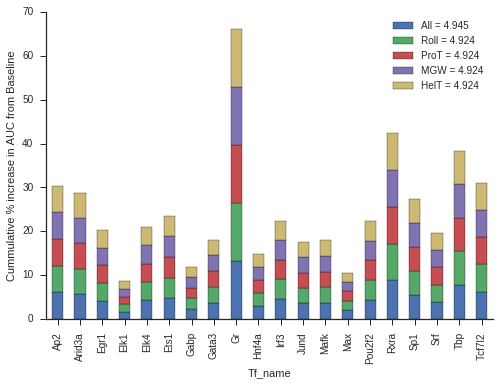

In [140]:
sns.set(style="ticks")

shape_df = ((TF_scores_shape.T - TF_scores_shape["None"])*100).T
del shape_df["None"]
axes = shape_df.plot.bar(stacked=True)
ave_additive = shape_df.mean()
leg = list(shape_df.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_additive[i]))
axes.legend(new_leg,loc='best')
axes.set_ylabel("Cummulative % increase in AUC from Baseline")
sns.despine(right=True)
plt.savefig("%s/feature_importance_dna_shape_additive.png" % figure_path, bbox_inches='tight')

## Contribution of noise or preferred k-mers to model quality

What is the overal contribution of the k-mer frequency difference to the prediction accuracy of the model?

Celarly, both provide some competitive advantage to the perfomance of the model, but preferred k-mers have the greatest benefit when combined with the baseline model. However, this advantage is not statistically significant (0.12982179737652688, Wilcoxon; -0.41421912013960499, Cohens effect size)

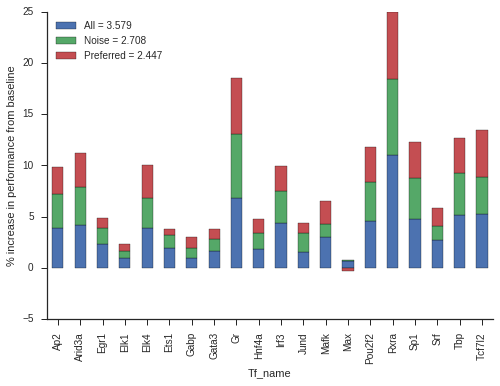

In [145]:

TF_scores_noise= pd.read_table("TF_scores_feature_importance_recursive_noise.txt", index_col="Tf_name")
del TF_scores_noise["Unnamed: 5"]
noise_df = ((TF_scores_noise.T - TF_scores_noise["None"])*100).T
del noise_df["None"]
noise_df = noise_df.T
#noise_df["Ave"] = noise_df.T.mean()

axes = noise_df.T.plot.bar(stacked=True)
ave_noise = noise_df.T.mean()
leg = list(noise_df.T.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_noise[i]))
    
axes.legend(new_leg,loc='best')
sns.despine()
axes.set_ylabel("% increase in performance from baseline")
#axes.set_label("test")
plt.savefig("%s/feature_importance_kmer_noise_additive.png" % figure_path, bbox_inches='tight')

In [24]:
get_stat_wilcoxon_effect_size(TF_scores_noise.All,TF_scores_noise["None"])

(0.12982179737652688, -0.41421912013960499)

Get the details of average perfomance of each of these plots

In [148]:
sns.set(style="whitegrid")

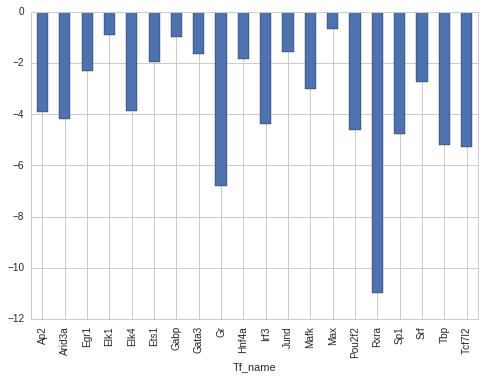

In [149]:
axes = ((TF_scores_noise.T - TF_scores_noise["All"])*100).T["None"].plot.bar()

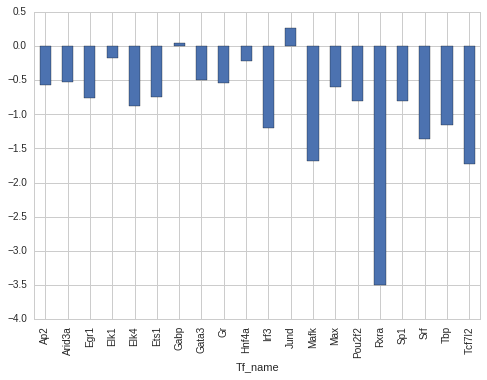

In [150]:
axes = ((TF_scores_noise.T - TF_scores_noise["All"])*100).T["Noise"].plot.bar()

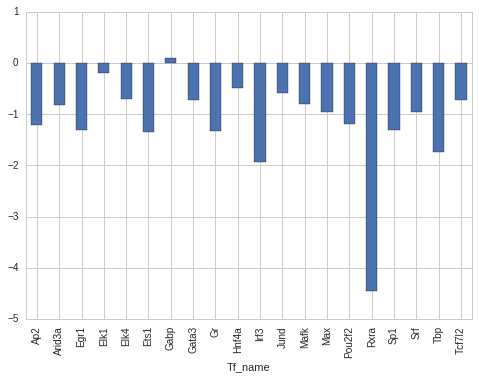

In [151]:
axes = ((TF_scores_noise.T - TF_scores_noise["All"])*100).T["Preferred"].plot.bar()

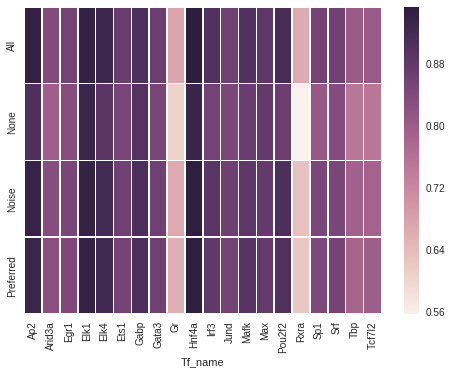

In [152]:
sns.heatmap(TF_scores_noise.T)

## The contribution of various conservation features

Interestingly, this breaks my previous assumption that geting conservation information from a hit site is more infromative that getting similar information from the whole sequence. 

We observe a significant improvement in model perfomance when the conservation score are used compared to that without (0.023073981745790676,Wicoxon;-0.65656562523773154, Cohens effect size)

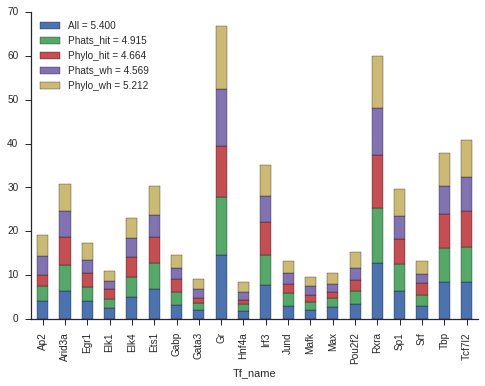

In [245]:
TF_scores_conservation= pd.read_table("TF_scores_feature_importance_recursive_conservation.txt", index_col="Tf_name")
del TF_scores_conservation["Unnamed: 7"]
conservation_df = ((TF_scores_conservation.T - TF_scores_conservation["None"])*100).T
del conservation_df["None"]
conservation_df = conservation_df.T
#noise_df["Ave"] = noise_df.T.mean()

axes = conservation_df.T.plot.bar(stacked=True)
ave_conserve = conservation_df.T.mean()
leg = list(conservation_df.T.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_conserve[i]))
    
axes.legend(new_leg,loc='best')
sns.despine()
plt.savefig("%s/feature_importance_conservation_stacked.png" % figure_path, bbox_inches='tight')

In [248]:
#conservation_df.T.plot.box()

In [432]:
get_stat_wilcoxon_effect_size(TF_scores_conservation.None, TF_scores_conservation.Phylo_wh)

(0.034866371928888917, 0.62840849060654058)

In [433]:
get_stat_wilcoxon_effect_size(TF_scores_conservation.Phylo_hit, TF_scores_conservation.None)

(0.065855484238296555, -0.56124850198948961)

In [116]:
wilcoxon(TF_scores_conservation.None, TF_scores_conservation.Phats_hit)

WilcoxonResult(statistic=0.0, pvalue=8.8574576878635474e-05)

In [435]:
get_stat_wilcoxon_effect_size(TF_scores_conservation.None, TF_scores_conservation.Phats_wh)

(0.058290580139488755, 0.54635040425882297)

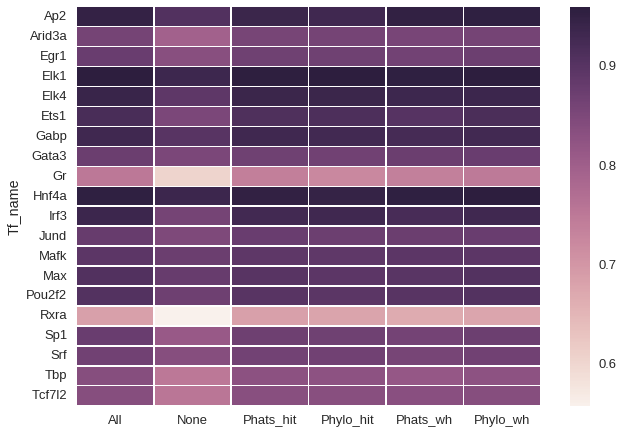

In [325]:
sns.heatmap(TF_scores_conservation)

## How well the models can generalize to other cell types

Little variation in th AUC scores in different cell lines is observed. 

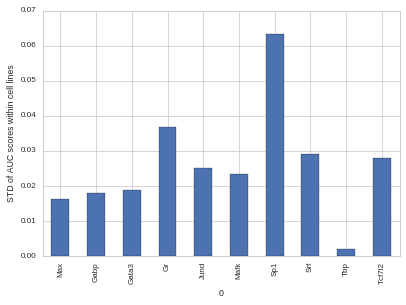

In [158]:
TF_scores_cell_type= pd.read_table("TF_scores_cell_type_specificity.txt", header=None)
TF_scores_cell_type = TF_scores_cell_type.T
axes = (TF_scores_cell_type.T.set_index(0).T.std()).plot(kind="bar")
axes.set_ylabel("STD of AUC scores within cell lines")
#axes.set_label("test")
plt.savefig("%s/feature_importance_cell_type_std.png" % figure_path, bbox_inches='tight')

In [456]:
TF_scores_cell_type

,0,1,2,3,4,5,6,7,8,9
0,Max,Gabp,Gata3,Gr,Jund,Mafk,Sp1,Srf,Tbp,Tcf7l2
1,0.958198,0.960868,0.864922,0.847034,0.957463,0.944233,0.808132,0.955344,0.88878,0.830001
2,0.935295,0.980067,0.886676,0.781577,0.931953,0.918508,0.924416,0.898882,0.887654,0.881673
3,0.956797,0.985118,0.902706,0.865817,0.946501,0.953272,0.909609,0.913879,0.890357,0.844154
4,0.975867,0.943196,NaN,0.815509,0.96577,0.893958,NaN,NaN,0.89269,0.90638
5,0.936539,0.951723,NaN,0.78673,0.92199,0.922007,NaN,NaN,NaN,0.848099
6,0.94634,NaN,NaN,NaN,0.982075,NaN,NaN,NaN,NaN,0.85639
7,0.962907,NaN,NaN,NaN,0.910938,NaN,NaN,NaN,NaN,NaN
8,0.927739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


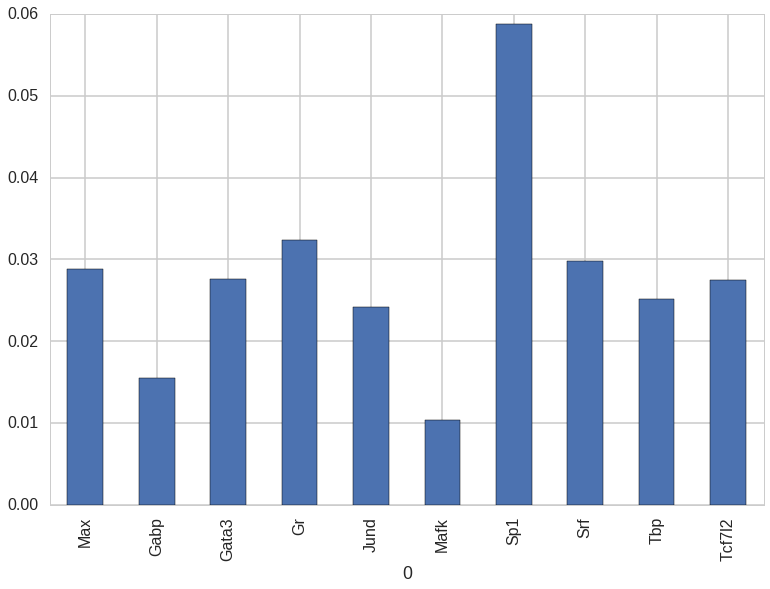

In [24]:
TF_scores_cell_type= pd.read_table("TF_scores_cell_type_specificity_1.txt", header=None)
TF_scores_cell_type = TF_scores_cell_type.T
(TF_scores_cell_type.T.set_index(0).T.std()).plot(kind="bar")
#plt.savefig("%s/feature_importance_cell_type_std.pdf" % figure_path, bbox_inches='tight')

In [163]:
#(TF_scores_cell_type.T.set_index(0).T/TF_scores_cell_type.T.set_index(0).T.sum()).T.plot.bar(stacked=True)

How best can we present this information?

In [164]:
#TF_scores_cell_type.T.set_index(0).plot.bar(stacked=True)

In [42]:
pd.read_table("TF_scores_cell_type_specificity_recursive.txt", header=None).head(9)

,0,1,2,3,4,5,6,7,8,9,10
0,HaibK562MaxV0416102,0.999987,0.958198,0.935295,0.956797,0.975867,0.936539,0.946340,0.962907,0.927739,NaN
1,SydhHepg2MaxIggrab,0.883680,0.999997,0.936731,0.929316,0.985384,0.935008,0.940829,0.966806,0.917436,NaN
2,SydhH1hescMaxUcd,0.851800,0.941161,0.999999,0.898430,0.975349,0.905853,0.935883,0.946978,0.894248,NaN
3,SydhK562MaxIggrab,0.913657,0.970906,0.939700,0.999994,0.985880,0.946690,0.953512,0.974443,0.941194,NaN
4,SydhHuvecMax,0.872850,0.958243,0.937173,0.919214,0.999999,0.930080,0.942075,0.962154,0.915155,NaN
5,SydhGm12878MaxIggmus,0.878796,0.958363,0.929573,0.925348,0.981261,1.000000,0.937333,0.963661,0.921895,NaN
6,SydhNb4Max,0.889055,0.963251,0.949503,0.937675,0.987276,0.938957,0.999993,0.967734,0.933193,NaN
7,SydhA549MaxIggrab,0.877824,0.961319,0.931708,0.923296,0.985515,0.933408,0.937572,0.999997,0.918693,NaN
8,SydhHelas3MaxIggrab,0.886987,0.960000,0.933015,0.939778,0.982428,0.941678,0.946053,0.970418,0.999998,NaN


In [166]:
def get_from_clip(Tf_name=""):
    Srf_cell = pd.read_clipboard(header=None)
    Srf_cell.set_index(0, inplace=True)
    Srf_cell.columns = Srf_cell.index
    ax=sns.heatmap(Srf_cell, annot=True)
    ax.set_ylabel("Model's predictive ability")
    ax.set_xlabel("Cell line's ease of prediction")
    plt.savefig("%s/cell_line_specificity_%s.pdf" % (figure_path,Tf_name),bbox_inches='tight')
    return Srf_cell

In [ ]:
HaibK562MaxV0416102	0.999986692967	0.958197588862	0.935294871735	0.956796811308	0.975866675334	0.936539068595	0.946339768386	0.96290706121	0.927738576426
SydhHepg2MaxIggrab	0.88368022443	0.999997038435	0.936730684257	0.929315789505	0.985383714178	0.935008270043	0.940828661509	0.966806458328	0.917435670526
SydhH1hescMaxUcd	0.851800289149	0.941161426184	0.999998782343	0.898429965086	0.975349244955	0.905853233142	0.935883244649	0.946978339324	0.894248360364
SydhK562MaxIggrab	0.913657458184	0.970905808791	0.939700111518	0.999994389722	0.985880467575	0.946689912918	0.953511594735	0.974443353218	0.941193868436
SydhHuvecMax	0.872849536241	0.958242597332	0.937172693777	0.919214023559	0.999999430909	0.930080317854	0.942074614549	0.962153511845	0.915154656178
SydhGm12878MaxIggmus	0.878795769406	0.958362558979	0.929572711467	0.925348251119	0.981261154188	1.0	0.937333247008	0.963661467185	0.921894680201
SydhNb4Max	0.889054934034	0.963251114938	0.949502591954	0.937675028191	0.987275942466	0.938957116199	0.999993152566	0.967734274348	0.933193314552
SydhA549MaxIggrab	0.877824347344	0.961318639195	0.931707605272	0.923295936803	0.985515427178	0.933408287249	0.937572262624	0.999996573559	0.918692693847
SydhHelas3MaxIggrab	0.886986956047	0.959999755762	0.93301517415	0.939777548258	0.982428360269	0.941677715308	0.946052530135	0.970418302078	0.999998039865

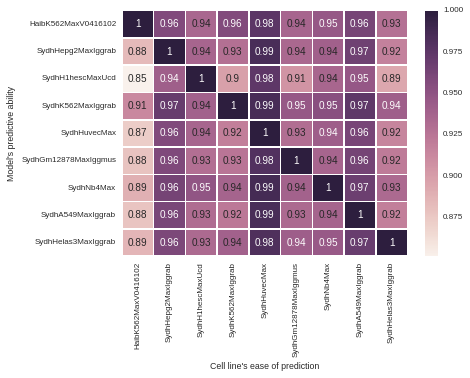

In [167]:
a = get_from_clip("Max")

In [169]:
a.mean()

0
HaibK562MaxV0416102     0.894960
SydhHepg2MaxIggrab      0.963493
SydhH1hescMaxUcd        0.943633
SydhK562MaxIggrab       0.936650
SydhHuvecMax            0.984329
SydhGm12878MaxIggmus    0.940913
SydhNb4Max              0.948843
SydhA549MaxIggrab       0.968344
SydhHelas3MaxIggrab     0.929950
dtype: float64

In [ ]:
HaibEcc1GrV0416102Dex100nm	0.999994896345	0.847034174061	0.781577359061	0.865816633144	0.815508737617	0.786729600694
HaibA549GrPcr1xDex500pm	0.796755223591	1.0	0.745146527467	0.834682355711	0.786116808713	0.847520616319
HaibA549GrPcr2xDex100nm	0.836927210393	0.904874525801	0.999996187729	0.929371393049	0.899989962681	0.876112196181
HaibA549GrPcr1xDex5nm	0.846248000005	0.929524928176	0.82177798559	0.999997995191	0.874233258614	0.784505208333
HaibA549GrPcr1xDex50nm	0.858837760542	0.938858113363	0.895638035261	0.96628008075	0.999993796465	0.778510199653
SydhHepg2Grp20Forskln	0.726747746736	0.80100315868	0.736832031416	0.764097453588	0.724206477954	1.0

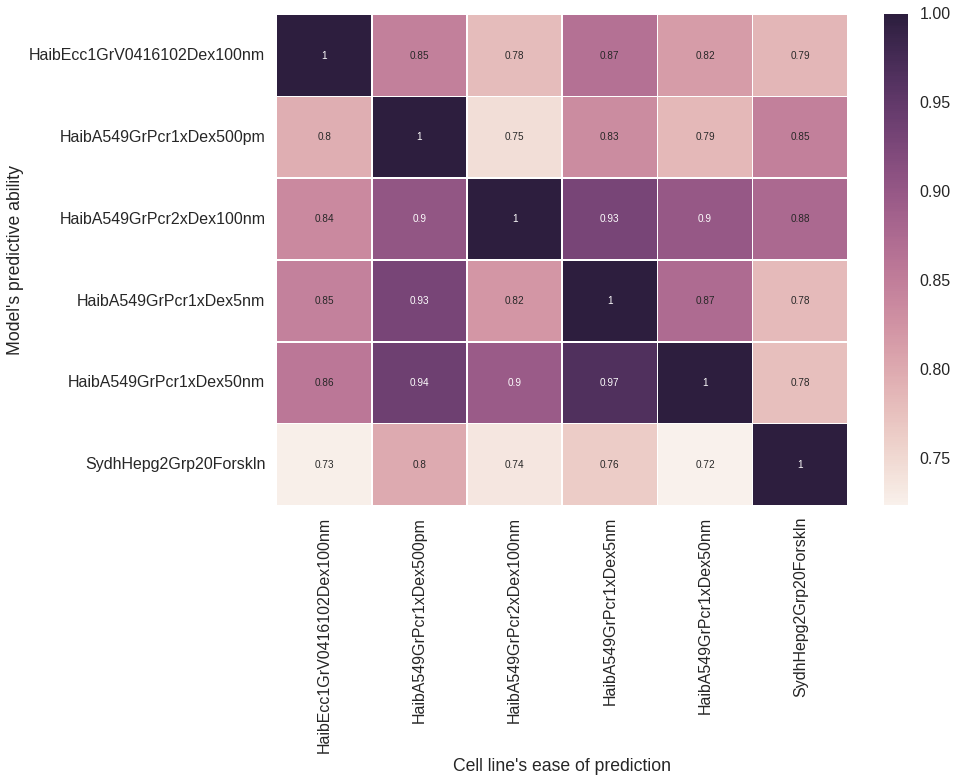

In [126]:
a = get_from_clip("Gr")

In [ ]:
SydhHelas3MafkIggrab	0.999999839407	0.944233299534	0.91850804104	0.95327168224	0.893957524699	0.922007161238
SydhK562Mafkab50322Iggrab	0.957029843243	0.999999899545	0.92821786613	0.966853854631	0.901934259634	0.929096153358
SydhHepg2Mafksc477Iggrab	0.967331082836	0.96769472819	0.99999976076	0.967324021099	0.951798509594	0.963017262504
SydhH1hescMafkIggrab	0.942554228852	0.942110839459	0.910073205292	0.999999751333	0.883645248998	0.908519027801
SydhHepg2Mafkab50322Iggrab	0.963561763796	0.962392897562	0.98710179776	0.962507596766	0.999999835161	0.978063825358
SydhImr90MafkIggrab	0.973414145885	0.968532044391	0.967534596354	0.969851282424	0.947212000913	0.999999737559

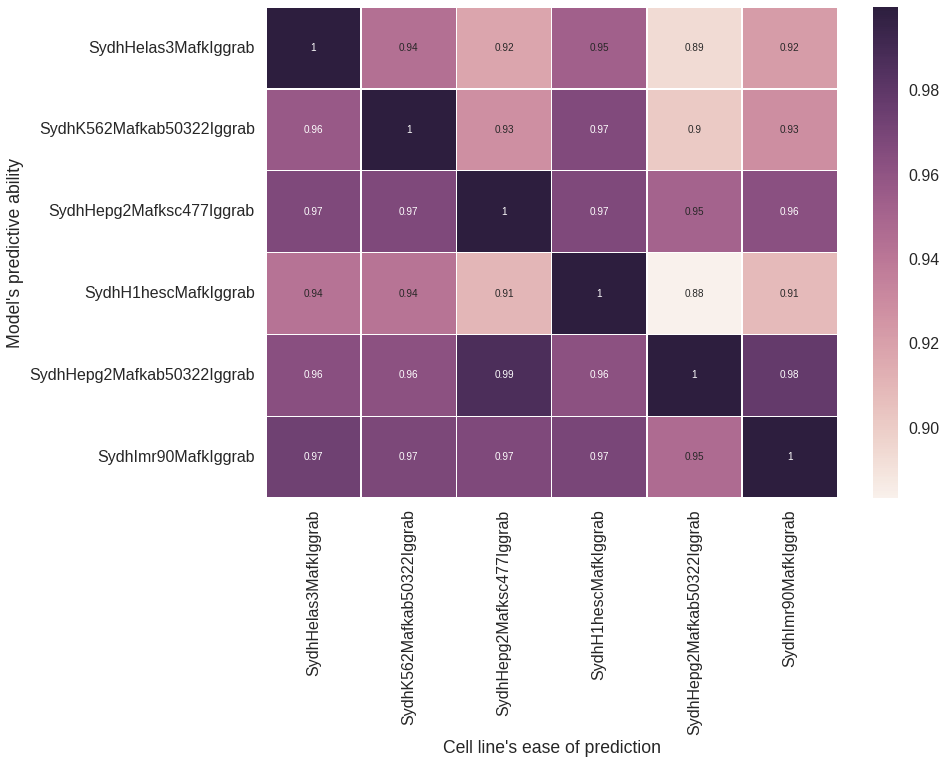

In [127]:
a = get_from_clip("Mafk")

In [ ]:
HaibK562SrfV0416101	1.0	0.955343896191	0.898881697585	0.913878991455
HaibH1hescSrfPcr1x	0.950684632456	1.0	0.895290350997	0.91903304798
HaibGm12878SrfPcr2x	0.964234400688	0.961231064825	0.999999661577	0.933875780486
HaibHepg2SrfV0416101	0.934006815357	0.945198819336	0.888843643592	1.0

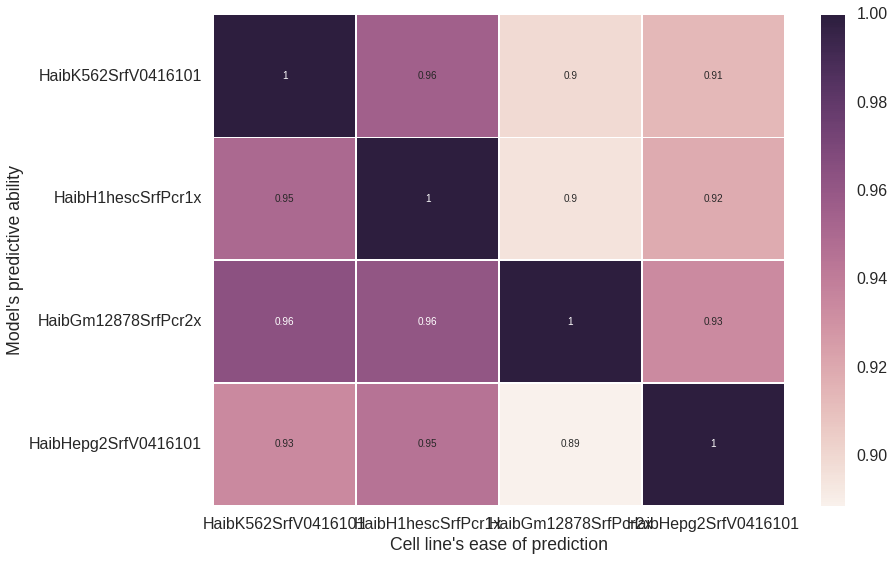

In [128]:
a = get_from_clip("Srf")

In [ ]:
SydhHepg2Tcf7l2Ucd	1.0	0.830001202439	0.881673460584	0.844153801706	0.906379877688	0.848099163354	0.856390466392
SydhPanc1Tcf7l2Ucd	0.897566531397	0.999999966838	0.913795539047	0.91606584823	0.954202217471	0.901324210418	0.893773525377
SydhMcf7Tcf7l2Ucd	0.901509533429	0.875816413245	1.0	0.89157861648	0.94883783971	0.896063840761	0.878445404664
SydhHct116Tcf7l2Ucd	0.882596106372	0.894890854958	0.9054022791	0.999998390126	0.953069292007	0.916618823243	0.87097037037
SydhHelas3Tcf7l2Ucd	0.884459910026	0.864505561827	0.892876440889	0.888146525848	0.999999392207	0.885228429014	0.864175994513
SydhHelas3Tcf7l2c9b92565Ucd	0.89716033039	0.892960453024	0.92138895693	0.925428022866	0.970298997507	1.0	0.881288751715
SydhHek293Tcf7l2Ucd	0.895980085332	0.871773651784	0.901436045173	0.876018040121	0.944868953831	0.876648682402	1.0

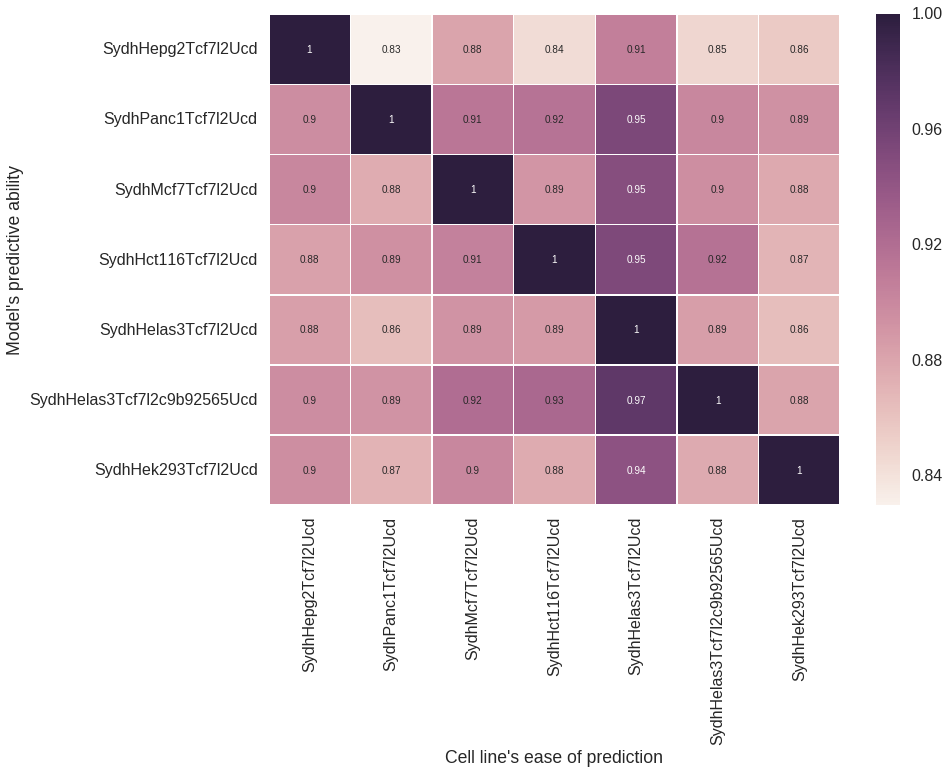

In [129]:
a = get_from_clip("Tcf7l2")

In [ ]:
HaibH1hescGabpPcr1x	0.999999840764	0.960867517213	0.980066876049	0.985117700908	0.943195549691	0.951722582416
HaibHepg2GabpPcr2x	0.984586864137	0.99999705081	0.990751357849	0.989994422129	0.948842758865	0.961377487892
HaibGm12878GabpPcr2x	0.984368073213	0.97227544589	0.999997249982	0.991618509307	0.949218862094	0.959380131057
HaibHelas3GabpPcr1x	0.982927460777	0.966901099642	0.986506649325	0.999999021044	0.948974357164	0.955454021623
HaibK562GabpV0416101	0.981161846685	0.974385729753	0.991923855728	0.992773241709	0.999997197651	0.959822788107
HaibA549GabpV0422111Etoh02	0.981354841299	0.97044450564	0.985265400983	0.986912778981	0.949271490204	1.0

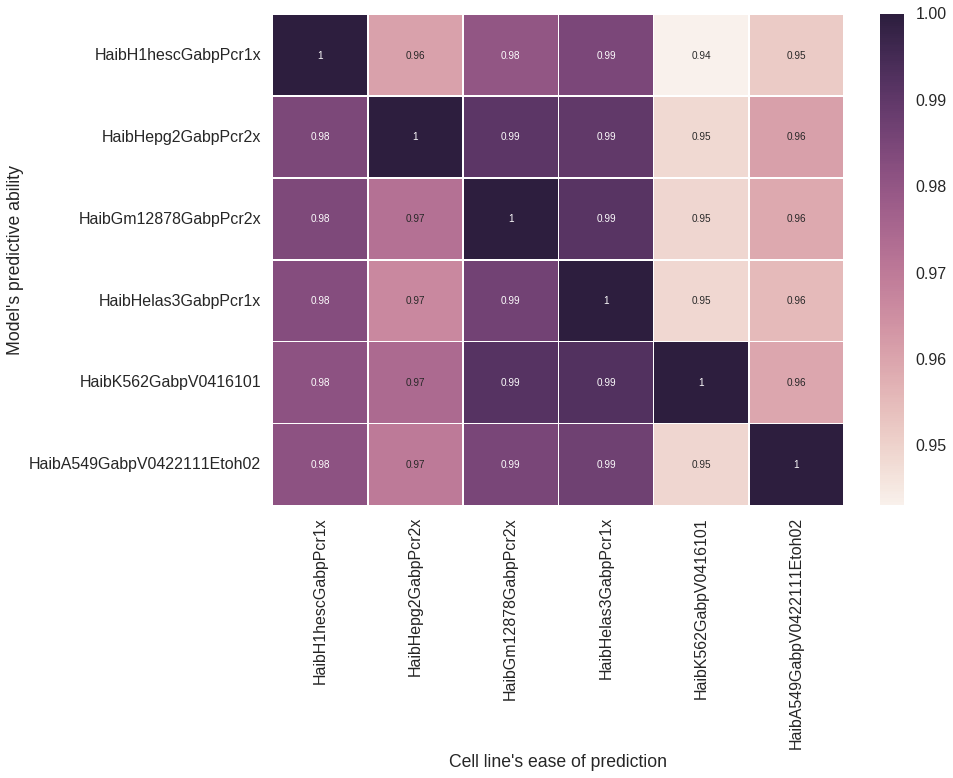

In [130]:
a = get_from_clip("Gabp")

In [ ]:
SydhGm12878TbpIggmus	0.999997952964	0.888779855571	0.88765369382	0.89035703374	0.892690416004
SydhK562TbpIggmus	0.863770794852	0.999996926049	0.920930756828	0.865533508169	0.908939463208
SydhH1hescTbpIggrab	0.858187188446	0.925101519518	0.999992103708	0.855139342183	0.91505886472
SydhHelas3TbpIggrab	0.884523114422	0.880087648721	0.873358338041	0.999998325868	0.883791440593
SydhHepg2TbpIggrab	0.878845192731	0.91945196067	0.920381263	0.873888481052	0.999993966251

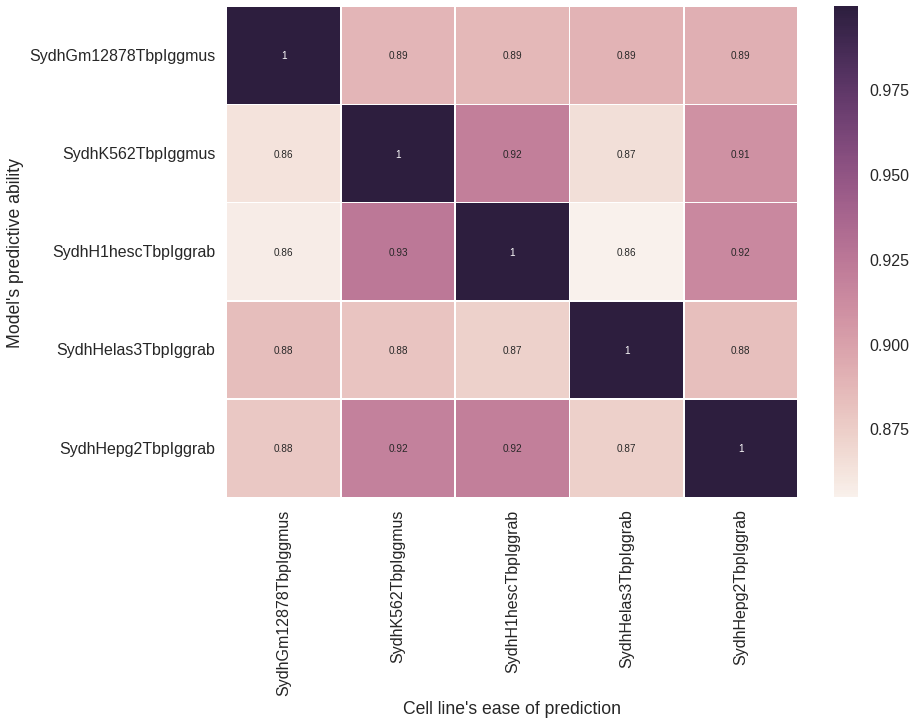

In [131]:
a = get_from_clip("Tbp")

In [ ]:
SydhH1hescJundIggrab	0.999999356778	0.931952805269	0.946500630701	0.965770427936	0.921989690526	0.982075384071	0.91093763367
SydhGm12878Jund	0.891758105496	1.0	0.893208669016	0.935962454566	0.88237754802	0.968701531172	0.765159891639
SydhK562JundIggrab	0.971976515235	0.928125247991	0.999998364007	0.976740114714	0.94242154761	0.983810501514	0.911314851442
SydhHepg2JundIggrab	0.941422879421	0.949503452029	0.939599303394	0.999999676733	0.92649341113	0.985397733197	0.848549367709
HaibHepg2JundPcr1x	0.953778395589	0.937597070594	0.94955885285	0.958001592056	0.999998142454	0.981376137366	0.907557078043
SydhHelas3JundIggrab	0.945257128155	0.95916799873	0.940145296012	0.974108672541	0.923423777617	0.999999129316	0.84984063847
HaibH1hescJundV0416102	0.961245635915	0.89580428301	0.933278218532	0.936304821764	0.91822754536	0.965858345835	0.99999817204

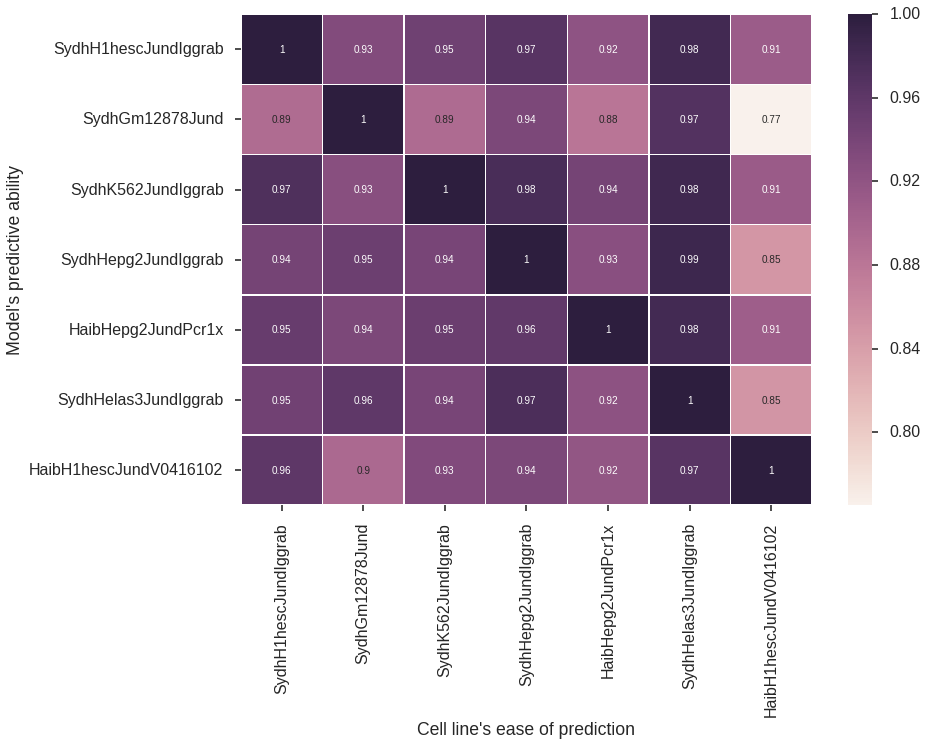

In [141]:
a = get_from_clip("Jund")

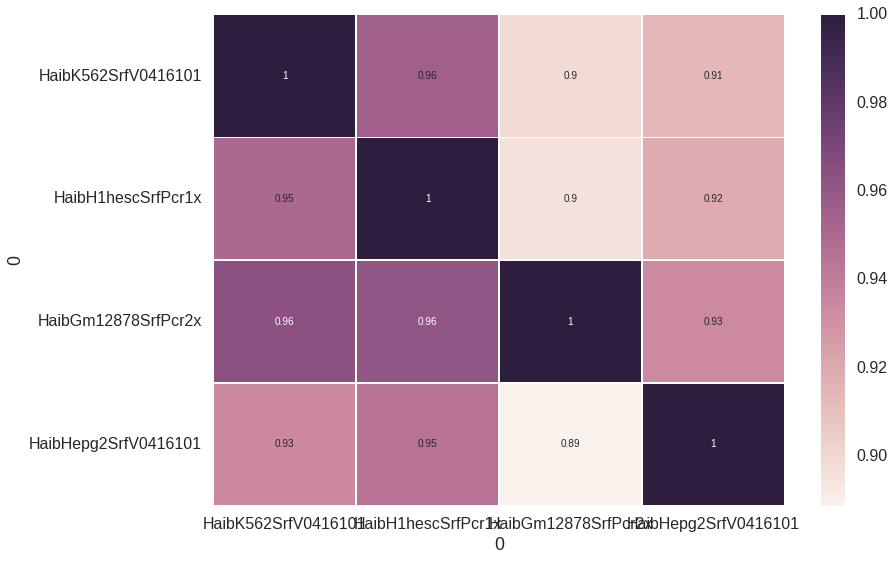

In [84]:
Srf_cell = pd.read_clipboard(header=None)
Srf_cell.set_index(0, inplace=True)
Srf_cell.columns = Srf_cell.index
Srf_cell.T.mean()
sns.heatmap(Srf_cell, annot=True)

In [ ]:
TF_scores_cell_type_specificity_1.txt

In [ ]:
Gabp
['HaibH1hescGabpPcr1x', 'HaibHepg2GabpPcr2x', 'HaibGm12878GabpPcr2x', 'HaibHelas3GabpPcr1x', 'HaibK562GabpV0416101', 'HaibA549GabpV0422111Etoh02']
Gata3
['HaibT47dGata3sc268V0416102Dm002p1h', 'SydhShsy5yGata3sc269sc269Ucd', 'SydhMcf7Gata3Ucd', 'SydhMcf7Gata3sc269Ucd']
Jund
['SydhH1hescJundIggrab', 'UchicagoK562Ejund', 'SydhGm12878Jund', 'SydhK562JundIggrab', 'SydhHepg2JundIggrab', 'HaibHepg2JundPcr1x', 'SydhHelas3JundIggrab', 'HaibH1hescJundV0416102']
Mafk
['SydhHelas3MafkIggrab', 'SydhK562Mafkab50322Iggrab', 'SydhHepg2Mafksc477Iggrab', 'SydhH1hescMafkIggrab', 'SydhHepg2Mafkab50322Iggrab', 'SydhImr90MafkIggrab']
Max
['HaibK562MaxV0416102', 'SydhHepg2MaxIggrab', 'SydhH1hescMaxUcd', 'SydhK562MaxIggrab', 'SydhHuvecMax', 'SydhGm12878MaxIggmus', 'SydhNb4Max', 'SydhA549MaxIggrab', 'SydhHelas3MaxIggrab']
Sp1
['HaibK562Sp1Pcr1x', 'HaibHepg2Sp1Pcr1x', 'HaibGm12878Sp1Pcr1x', 'HaibH1hescSp1Pcr1x']
Srf
['HaibK562SrfV0416101', 'HaibH1hescSrfPcr1x', 'HaibGm12878SrfPcr2x', 'HaibHepg2SrfV0416101']
Tbp
['SydhGm12878TbpIggmus', 'SydhK562TbpIggmus', 'SydhH1hescTbpIggrab', 'SydhHelas3TbpIggrab', 'SydhHepg2TbpIggrab', 'SydhH1hescCtbp2Ucd']
Tcf7l2
['SydhHepg2Tcf7l2Ucd', 'SydhPanc1Tcf7l2Ucd', 'SydhMcf7Tcf7l2Ucd', 'SydhHct116Tcf7l2Ucd', 'SydhHelas3Tcf7l2Ucd', 'SydhHelas3Tcf7l2c9b92565Ucd', 'SydhHek293Tcf7l2Ucd']

In [39]:
#combine = pd.read_table("TF_scores_feature_importance_recursive_shape2.txt", index_col="Tf_name")
#tst3["None"] = combine["None"]
#tst3.to_csv("TF_scores_feature_importance_recursive_shape.txt", sep="\t", index_label=False)

## Create a table in Latex

In [459]:
cl = pd.read_clipboard(i)

In [462]:
cl.set_index("Cell Line ID", inplace=True)

In [464]:
cl.to_latex("%s/test.tex" % figure_path)

## Test all models

In [226]:
all_cl = pd.read_table("TF_scores.txt", index_col="Tf_name")

all_cl["pwm_score"] = 1-all_cl["pwm_score"]
del all_cl["Unnamed: 14"]
all_cl = map_names_fun(all_cl)

In [225]:
map_names["HelT_shape"] = "HelT"

In [250]:
sns.set_context("poster")

In [251]:
sns.set(style="ticks")

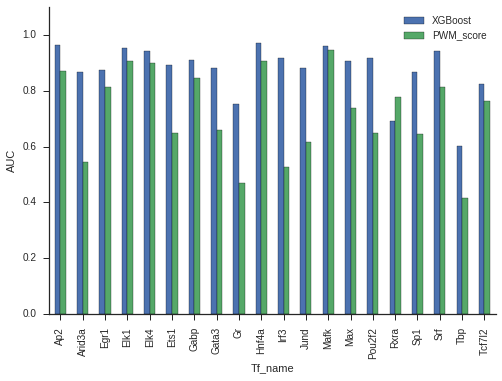

In [231]:
axes = all_cl[["XGBoost","PWM_score"]].plot(kind="bar")
axes.set_ylabel("AUC")
axes.set_ylim(0,1.1)
sns.despine()
plt.savefig("%s/machine_learning_benefit.png" % figure_path, bbox_inches='tight')

Miltifeatured model always better predictive than PWM or k-mer models on their own. "

In [233]:
all_mean.index.name = ["XGBoost", "sum_kmer_score", "max_kmer_score", "max_kmer_score_pos"]

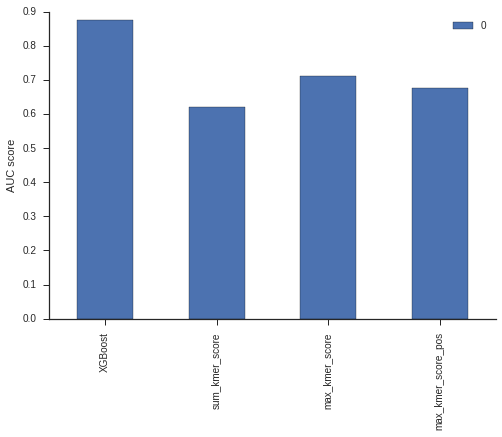

In [241]:
all_mean = all_cl[["XGBoost", "sum_kmer_score", "max_kmer_score", "max_kmer_score_pos"]].mean()
all_std = all_cl[["XGBoost", "sum_kmer_score", "max_kmer_score", "max_kmer_score_pos"]].std()

ax = pd.DataFrame(all_mean).plot.bar()
ax.set_ylabel("AUC score")
sns.despine()
#plt.savefig("%s/feature_kmer_scoring.png" % figure_path, bbox_inches='tight')

In [240]:
all_mean

XGBoost               0.875932
sum_kmer_score        0.621463
max_kmer_score        0.713034
max_kmer_score_pos    0.677712
dtype: float64

In [267]:
get_stat_wilcoxon_effect_size(all_cl.PWM_score, all_cl.sum_kmer_score)

(0.065855484238296555, -0.66966080402908323)

## Contigency table

Shows which features contribute unique information. 

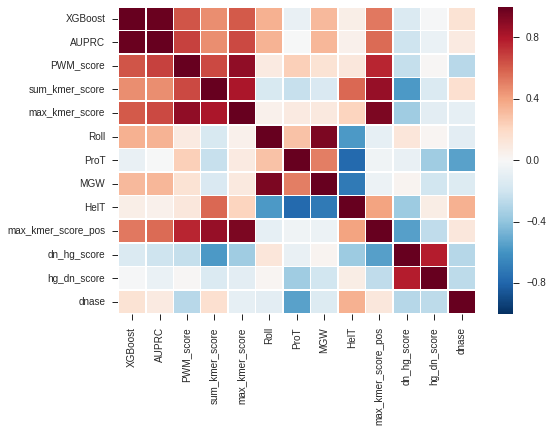

In [268]:
sns.heatmap(all_cl.corr())
plt.savefig("%s/feature_contigency.pdf" % figure_path, bbox_inches='tight')

## How to plot a scatter plot comparing two sets of data

With this established, all we need to do is to fine tune it

In [10]:
#feat_dict = feat_deatils[1].to_dict()

In [253]:
feat_imp = pd.read_table("TF_scores_feature_importance_recursive.txt", index_col="Tf_name")
feat_imp = feat_imp.T
feat_imp["Ave."] = feat_imp.T.mean()
feat_imp = feat_imp.T

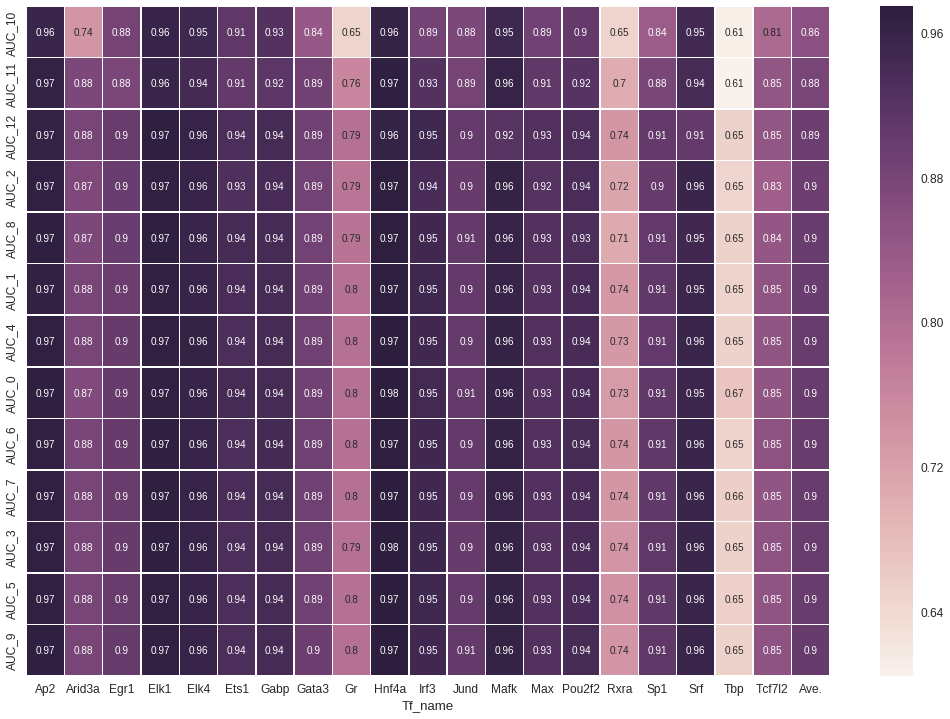

In [86]:
#sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
fig, ax1 = plt.subplots(figsize=(18, 12))
sns.heatmap(feat_imp.T.head(13).sort_values(by="Ave."), annot=True)
#fig = ax.get_figure()
plt.savefig('/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter5/Figs/feature_importance.pdf', bbox_inches='tight')

In [ ]:
feat_list = ['kmer_score',
 'max_kmer_score',"phatsCons",
 'Roll_shape', 'ProT_shape', 'MGW_shape', 'HelT_shape',
 'max_kmer_score_pos',
 'dn_hg_score',
 'dn_hg_score2',
 'dnase', "tss_dist","pwm_score"]

In [2]:
test_scores = pd.read_table("TF_scores.txt")
test_scores['pwm_score'] = 1-test_scores['pwm_score']
test_scores = test_scores.drop("Unnamed: 14", 1)
test_scores.set_index("Tf_name", inplace=True)
test_scores["dn_hg_score"] = 1 - test_scores["dn_hg_score"]

In [63]:
test_scores

,AUC,AUPRC,pwm_score,kmer_score,max_kmer_score,Roll_shape,ProT_shape,MGW_shape,HelT_shape,max_kmer_score_pos,dn_hg_score,dn_hg_score2,dnase
Tf_name,,,,,,,,,,,,,
Ap2,0.963312,0.961249,0.871495,0.555311,0.832644,0.583817,0.690392,0.615434,0.335013,0.735639,0.620901,0.401589,0.768383
Arid3a,0.867585,0.860295,0.544483,0.519892,0.594941,0.549206,0.482150,0.536094,0.488455,0.586973,0.590288,0.456877,0.816357
Egr1,0.873036,0.892232,0.814066,0.716695,0.797052,0.564504,0.625325,0.581740,0.412669,0.773498,0.724284,0.409786,0.741286
Elk1,0.954325,0.959758,0.904939,0.908821,0.912534,0.522682,0.573933,0.539146,0.514140,0.883709,0.763960,0.402072,0.782684
Elk4,0.941571,0.949533,0.898677,0.919239,0.913569,0.495259,0.548794,0.507788,0.550158,0.888158,0.759533,0.415028,0.780695
Ets1,0.891418,0.882630,0.648226,0.652973,0.698314,0.528560,0.532783,0.531234,0.511714,0.675225,0.725310,0.400156,0.805916
Gabp,0.911341,0.921376,0.844822,0.799337,0.843975,0.529456,0.540100,0.531736,0.520528,0.814267,0.745192,0.408433,0.750473
Gata3,0.883029,0.885885,0.659032,0.617739,0.753667,0.540948,0.546881,0.542427,0.450445,0.721937,0.635037,0.430934,0.772725
Gr,0.752219,0.685865,0.467929,0.598656,0.586057,0.476611,0.531102,0.481436,0.476474,0.583640,0.591093,0.456814,0.744775


### Combining PBM and DNase plots

In [269]:
combined_list = ['Tcf3',
 'Hnf4a',
 'Foxa2',
 'Irf3',
 'Tbp',
 'Irf4',
 'Ap2',
 'Max',
 'Sp4',
 'Jund',
 'Nr2f2',
 'Gata3',
 'Arid3a',
 'Srf',
 'Tcf7l2',
 'Gabp',
 'Egr1',
 'Rxra',
 'Mafk',
 'Sp1']

In [270]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed"])
for tf in combined_list:
    tfs = name2pbmchip[tf]
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/ChIP_seq/Results"
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results"
    #test = pd.read_table("%s/%s/%s.energy" % (f1000, tfs,tfs), index_col="Motif")
    energy = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s.max_kmer" % (tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    # Use this to add each to a specific column fro plotting purpose
    #print tf
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    #scaled = new_test[new_test.index.str.contains("scaled")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs,observed]], columns=["Tf_name","Sticky", "minmax","minabs", "observed"])
    plot_df = plot_df.append(df2)
    
    #print new_test
plot_df.set_index("Tf_name", inplace=True)
plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
plot_df.plot(kind="bar")

NameError: name 'name2pbmchip' is not defined

In [132]:
wilcoxon(plot_df.Sticky, plot_df.observed)

WilcoxonResult(statistic=102.5, pvalue=0.92562714910176558)

In [79]:
sticky_kmer = """CCCCGCCC
AAAAAAAA
GAAAAAAA
GGAAAAAA
CGAAAAAA
ATTATTTA
ATATTAAA
AGAACAAA
TTAATAAA
AACAAAAA
AATTAATA
ATAAATTA
GGAGATAA
ATAAAAAG
GGTAACAA
GAGATAAA
AATAAATA
AAATGATA
ATTTGTTC
AAGAACAA
ATAAACGA
ACAAAGAA
AAAACAAA
GGGGGAGA
GGGGGAAA
GTGGGGAA
AACAATAT
TTGATAAA
CATAACAA
AATATTAA
CCGCCCCA
GGTGGGGA
CCATAACA
AACCAAAA
AATTATCA
GGCGGGGA
TTATAAAA
ATTAGATG
ATAAGAAA
ATTAAAAA
TAACAAAA
CCCTCCCC
ATTTTACC
TTAAAAAA
AACTAATA
AACAAGAA
AGTAGGGG
ATAATAAA
TATAAAAA
AGTTTTAT""".split()

In [ ]:
hg_dn = dn_gapless.copy()
dn_hg = dn_gapless.copy()

hg_dn["counts"] = (hg_gapless["counts"]/sum(hg_gapless["counts"])) - (dn_gapless["counts"]/sum(dn_gapless["counts"]))
dn_hg["counts"] = (dn_gapless["counts"]/sum(dn_gapless["counts"])) - (hg_gapless["counts"]/sum(hg_gapless["counts"]))

In [83]:
hg_dn = pd.read_table("dn_hg_max_normalized.txt")

In [85]:
sticky = hg_dn.ix[sticky_kmer]

In [87]:
sticky = pd.read_clipboard()

In [91]:
sticky.set_index("k-mers", inplace=True)

In [94]:
import matplotlib

In [120]:
sticky.to_csv("sticky_kmers_hg_dn.txt", sep="\t")

## Sticky k-mer figure

In [138]:
sns.set(style="ticks", context="poster")


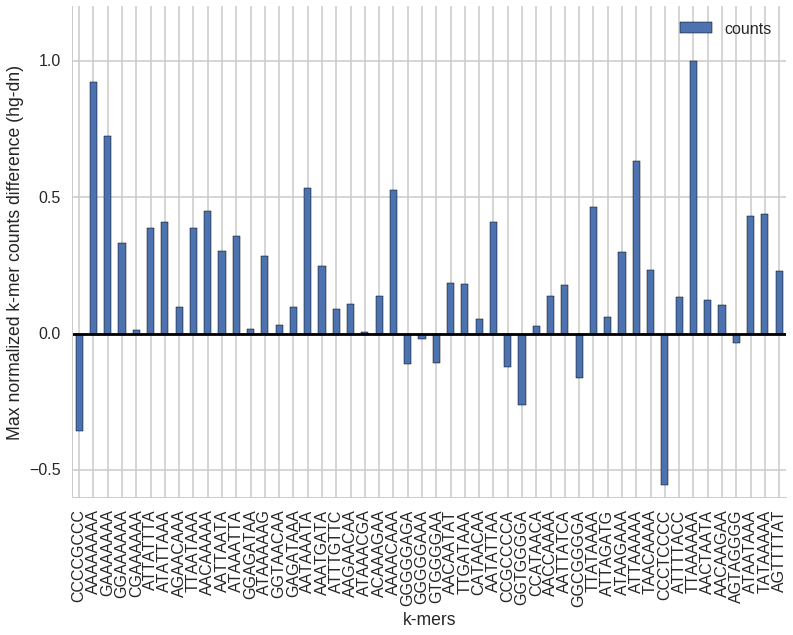

In [7]:
# sticky = hg_dn.ix[sticky_kmer]
# sticky = sticky/sticky["counts"].max()
#matplotlib.style.use('ggplot')
sticky = pd.read_table("sticky_kmers_hg_dn.txt", index_col="k-mers")
ax = sticky.plot(kind='bar')
sns.despine()
ax.set_ylabel("Max normalized k-mer counts difference (hg-dn)")
plt.axhline(0, color='k')
plt.savefig("/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter6/Figs/sticky_kmer_bar.png", bbox_inches='tight')